### SVM with generalization bounds

In [2]:
from sklearn import svm
import ScenarioGeneralizationBounds as SBn
import numpy as np
import matplotlib.pyplot as plt

 # define a data-generating-mechanism (DGM) generates a set of instanes and classes
def DGM(N1,rateo):
    N2=round(N1*rateo) 
    mean12=[1,1]
    mean34=[-4,-2]
    cov12=[[1, 0.9], [0.9, 10]] 
    cov34=[[7, 0.1], [0.1, 1]] 
    x1 , x2 = np.random.multivariate_normal(mean12, cov12, N1).T
    x3 , x4 = np.random.multivariate_normal(mean34, cov34, N2).T 
    x1=x2+x1**2
    Xa=np.append(x1,x3)
    Xb=np.append(x2,x4)
    # Build data
    X =  np.transpose([Xa, Xb]) # X of shape (n_samples, n_features)  
    y =  np.append(np.zeros(N1), np.ones(N2))  
    return X, y ,x1 , x2, x3, x4

Text(0, 0.5, 'X2')

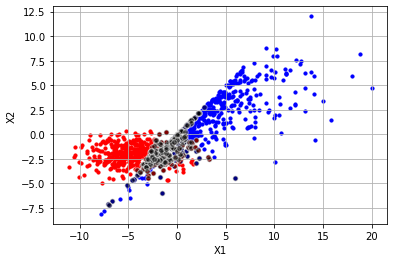

In [3]:
# sample from the DGM
Rateo=1
N1=500
X,y , x1 , x2, x3, x4 = DGM(N1,Rateo) 
# fit svm model
clf = svm.SVC(kernel='poly', degree=3, gamma='auto', C=1.0)
#clf = svm.SVC(kernel='linear', gamma=1, C=1.0)

clf.fit(X, y)
# plot the data and support vectors
plt.grid(True)
plt.scatter(x1,x2, facecolors='b', s=10)
plt.scatter(x3,x4, facecolors='r',s=10)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=30, facecolors='k', alpha=0.5  ,   zorder=10, edgecolors='w')
plt.xlabel('X1')
plt.ylabel('X2')

### Scenario bound on the violation probability


In [3]:
N=np.size(y) #  number of samples 
Nsv=np.sum(clf.n_support_) #  number of support vectors
print("Number of support vectors:",Nsv)
beta=10**-6 #  number parameter
Lb,Ub =SBn.getepsilon_relaxedConstraints(Nsv,N,beta) #  get bounds on the probability of margin violation
print("Upper bound on the Probability of miscalssification:", Ub) 

Number of support vectors: 349
Upper bound on the Probability of miscalssification: 0.43946625709431664


### Verify bounds (MC samping from the DGM to approx the true probability of misclassification)

In [4]:
# def Validate_ScenarioBound() 
N1t=100000
Xtst,ytst , x1t , x2t, x3t, x4t = DGM(N1t,Rateo)   
ypred = clf.predict(Xtst) 
Pmisclass=np.mean(np.array([ytst!=ypred])) # MC estimate of the true pribability of misclassification
if Pmisclass>Ub:
    raise AssertionError()
elif Pmisclass<=Ub:
    print("Bound verified P_miscalssification <= Scenario-based upper bound:" ,  Pmisclass, "<=", Ub) 

Bound verified P_miscalssification <= Scenario-based upper bound: 0.15518 <= 0.43946625709431664


In [5]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in 
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional 
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy
 
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier. 
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


### Plot  boundaries for different SVM models

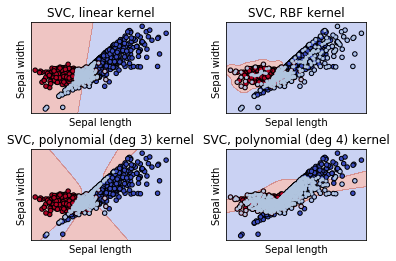

In [6]:
# we create an instance of SVM and fit out data. 
# If we scale our data there might be an issue in plotting the support vectors.??

C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C), 
          svm.SVC(kernel='rbf', gamma='auto', C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C),
          svm.SVC(kernel='poly', degree=4, gamma='auto', C=C))
MODELS = [clf.fit(X, y) for clf in models]
Nsv_models = [np.sum(clf.n_support_) for clf in MODELS] 
 
    
# title for the plots
titles = ('SVC, linear kernel', 
          'SVC, RBF kernel',
          'SVC, polynomial (deg 3) kernel',
          'SVC, polynomial (deg 4) kernel')
# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4, )

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(MODELS, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.3)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=10,
                facecolors="lightsteelblue", zorder=10, edgecolors='none')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

### Compute scenario-bounds for SVM trained with different kernels, validate bounds via MC sampling

In [7]:
for nsv,clf in zip(Nsv_models, MODELS):
    print("Number of support vectors", nsv)
    Lb,Ub =SBn.getepsilon_relaxedConstraints(nsv,N,beta) #  get bounds on the probability of margin violation
    N1t=100000 # samples for validation
    Xtst,ytst , x1t , x2t, x3t, x4t = DGM(N1t,Rateo)   
    ypred = clf.predict(Xtst)
    Pmisclass=np.mean(np.array([ytst!=ypred])) # MC estimate of the true pribability of misclassification 
    if Pmisclass>Ub:
          raise AssertionError()
    elif Pmisclass<=Ub:
         print("Bound verified P_miscalssification<=Scenario-based upper bound:" ,  Pmisclass, "<=", Ub) 

Number of support vectors 351
Bound verified P_miscalssification<=Scenario-based upper bound: 0.15168 <= 0.4415447251276394
Number of support vectors 359
Bound verified P_miscalssification<=Scenario-based upper bound: 0.109565 <= 0.4498418961345778
Number of support vectors 349
Bound verified P_miscalssification<=Scenario-based upper bound: 0.15436 <= 0.43946625709431664
Number of support vectors 764
Bound verified P_miscalssification<=Scenario-based upper bound: 0.38876 <= 0.8371914303502481


In [4]:
N_array=range(100,5000,100)
Nsv_array=np.zeros(np.size(N_array))
Pf_array=np.zeros(np.size(N_array))
Ub_array=np.zeros(np.size(N_array))
for n in range(0,np.size(N_array)):  
    X,y , x1 , x2, x3, x4 = DGM(N_array[n],Rateo) # genearate data 
    clf = svm.SVC(kernel='poly', gamma='auto', C=1.0) # define svm model
    clf.fit(X, y)# fit svm model
    
    N=np.size(y) #  number of samples 
    Nsv=np.sum(clf.n_support_) #  number of support vectors
    print("Number of support vectors:",Nsv) 
    Lb,Ub =SBn.getepsilon_relaxedConstraints(Nsv,N,10**-6) #  get bounds on the probability of margin violation
    print("Upper bound on the Probability of miscalssification:", Ub)  
    Ub_array[n]=Ub
    Nsv_array[n]=Nsv
    # def Validate_ScenarioBound() 
    N1t=100000
    Xtst,ytst , x1t , x2t, x3t, x4t = DGM(N1t,Rateo)   
    ypred = clf.predict(Xtst) 
    Pmisclass=np.mean(np.array([ytst!=ypred])) # MC estimate of the true pribability of misclassification
    Pf_array[n]=Pmisclass
    if Pmisclass>Ub:
        raise AssertionError()
    elif Pmisclass<=Ub:
        print("Bound verified P_miscalssification <= Scenario-based upper bound:" ,  Pmisclass, "<=", Ub) 
  

Number of support vectors: 62
Upper bound on the Probability of miscalssification: 0.5097823707849792
Bound verified P_miscalssification <= Scenario-based upper bound: 0.15117 <= 0.5097823707849792
Number of support vectors: 132
Upper bound on the Probability of miscalssification: 0.4719862001498456
Bound verified P_miscalssification <= Scenario-based upper bound: 0.15584 <= 0.4719862001498456
Number of support vectors: 207
Upper bound on the Probability of miscalssification: 0.46155025782060677
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14878 <= 0.46155025782060677
Number of support vectors: 231
Upper bound on the Probability of miscalssification: 0.38650670477135995
Bound verified P_miscalssification <= Scenario-based upper bound: 0.13947 <= 0.38650670477135995
Number of support vectors: 351
Upper bound on the Probability of miscalssification: 0.4415447251276394
Bound verified P_miscalssification <= Scenario-based upper bound: 0.152355 <= 0.4415447251276394
N

C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.15213 <= 0.4287292460168648
Number of support vectors: 594
Upper bound on the Probability of miscalssification: 0.39680104102596214


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.142165 <= 0.39680104102596214
Number of support vectors: 744
Upper bound on the Probability of miscalssification: 0.43675488927448924


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.15189 <= 0.43675488927448924
Number of support vectors: 829
Upper bound on the Probability of miscalssification: 0.43871298556041793


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.153445 <= 0.43871298556041793
Number of support vectors: 857
Upper bound on the Probability of miscalssification: 0.41585055069968235


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.14353 <= 0.41585055069968235
Number of support vectors: 894
Upper bound on the Probability of miscalssification: 0.3999283610060729


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.150585 <= 0.3999283610060729
Number of support vectors: 987
Upper bound on the Probability of miscalssification: 0.40681672480318654


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.14891 <= 0.40681672480318654
Number of support vectors: 1074
Upper bound on the Probability of miscalssification: 0.4106432115858234


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.149545 <= 0.4106432115858234
Number of support vectors: 1139
Upper bound on the Probability of miscalssification: 0.4068713056641462


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.150585 <= 0.4068713056641462
Number of support vectors: 1238
Upper bound on the Probability of miscalssification: 0.4137533819276924


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.154205 <= 0.4137533819276924
Number of support vectors: 1302
Upper bound on the Probability of miscalssification: 0.40986109026498063


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.152715 <= 0.40986109026498063
Number of support vectors: 1283
Upper bound on the Probability of miscalssification: 0.38391550684334086


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.14453 <= 0.38391550684334086
Number of support vectors: 1295
Upper bound on the Probability of miscalssification: 0.36845144580640876


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.146045 <= 0.36845144580640876
Number of support vectors: 1466
Upper bound on the Probability of miscalssification: 0.393399965251208


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.15019 <= 0.393399965251208
Number of support vectors: 1559
Upper bound on the Probability of miscalssification: 0.39779239178686165


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Bound verified P_miscalssification <= Scenario-based upper bound: 0.15344 <= 0.39779239178686165
Number of support vectors: 1557
Upper bound on the Probability of miscalssification: 0.38060505662355193
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14219 <= 0.38060505662355193
Number of support vectors: 1693
Upper bound on the Probability of miscalssification: 0.3943153441635566
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14888 <= 0.3943153441635566
Number of support vectors: 1771


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.39501113935047716
Bound verified P_miscalssification <= Scenario-based upper bound: 0.145075 <= 0.39501113935047716
Number of support vectors: 1773
Upper bound on the Probability of miscalssification: 0.38067178773682664
Bound verified P_miscalssification <= Scenario-based upper bound: 0.144805 <= 0.38067178773682664
Number of support vectors: 2052


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.41980797951378523
Bound verified P_miscalssification <= Scenario-based upper bound: 0.154025 <= 0.41980797951378523
Number of support vectors: 2042


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.4034547219713447
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14948 <= 0.4034547219713447
Number of support vectors: 1915
Upper bound on the Probability of miscalssification: 0.3675236362619404
Bound verified P_miscalssification <= Scenario-based upper bound: 0.1453 <= 0.3675236362619404
Number of support vectors: 2242


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.411352022319045
Bound verified P_miscalssification <= Scenario-based upper bound: 0.15209 <= 0.411352022319045
Number of support vectors: 2136
Upper bound on the Probability of miscalssification: 0.38100258849823976
Bound verified P_miscalssification <= Scenario-based upper bound: 0.15214 <= 0.38100258849823976
Number of support vectors: 2347


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.40309864752960345
Bound verified P_miscalssification <= Scenario-based upper bound: 0.154615 <= 0.40309864752960345
Number of support vectors: 2348


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3913758520974573
Bound verified P_miscalssification <= Scenario-based upper bound: 0.150955 <= 0.3913758520974573
Number of support vectors: 2355


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.38122315299049436
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14985 <= 0.38122315299049436
Number of support vectors: 2462


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.38623207248292424
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14677 <= 0.38623207248292424
Number of support vectors: 2501


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3813122979828233
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14846 <= 0.3813122979828233
Number of support vectors: 2595


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.38423953785701737
Bound verified P_miscalssification <= Scenario-based upper bound: 0.1491 <= 0.38423953785701737
Number of support vectors: 2613


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3767993359665339
Bound verified P_miscalssification <= Scenario-based upper bound: 0.15087 <= 0.3767993359665339
Number of support vectors: 2651


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3723513255812595
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14708 <= 0.3723513255812595
Number of support vectors: 2894


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3942576428417228
Bound verified P_miscalssification <= Scenario-based upper bound: 0.153045 <= 0.3942576428417228
Number of support vectors: 2807


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3740563783612496
Bound verified P_miscalssification <= Scenario-based upper bound: 0.146875 <= 0.3740563783612496
Number of support vectors: 2962


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.38418760925435125
Bound verified P_miscalssification <= Scenario-based upper bound: 0.150325 <= 0.38418760925435125
Number of support vectors: 2955


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3746333509103694
Bound verified P_miscalssification <= Scenario-based upper bound: 0.15154 <= 0.3746333509103694
Number of support vectors: 2986


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3699100567478977
Bound verified P_miscalssification <= Scenario-based upper bound: 0.149035 <= 0.3699100567478977
Number of support vectors: 3241


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3907595911531748
Bound verified P_miscalssification <= Scenario-based upper bound: 0.148675 <= 0.3907595911531748
Number of support vectors: 3169


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.37448739159895084
Bound verified P_miscalssification <= Scenario-based upper bound: 0.14666 <= 0.37448739159895084
Number of support vectors: 3306


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3815528277449014
Bound verified P_miscalssification <= Scenario-based upper bound: 0.145505 <= 0.3815528277449014
Number of support vectors: 3456


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.3896886354377934
Bound verified P_miscalssification <= Scenario-based upper bound: 0.15341 <= 0.3896886354377934
Number of support vectors: 3532


C:\Users\20194707\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Upper bound on the Probability of miscalssification: 0.38980403263361907
Bound verified P_miscalssification <= Scenario-based upper bound: 0.152425 <= 0.38980403263361907


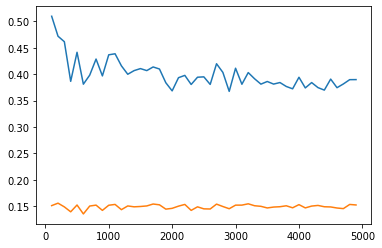

In [6]:
plt.plot(N_array,Ub_array)
plt.plot(N_array,Pf_array)